## IDRIS

# RNN Exercises
For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N


* Perform standard imports, load & plot the dataset (code provided)
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* OPTIONAL: Plot the results


## Performing standard imports, load and plot the dataset
Run the cells below to load the libraries needed for this exercise and the Energy Production dataset, and to plot the data.

In [2]:

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


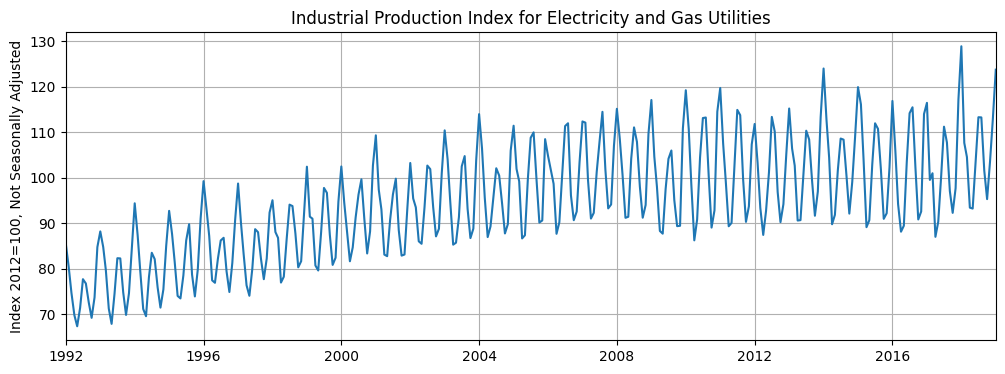

In [3]:

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

# Prepare the data
For the first set of exercises we'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

## 1. Dividing the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [4]:

y = df['IPG2211A2N'].values.astype(float)

test_size = 12
window_size = 12

train_set = y[:-test_size]
test_set = y[-test_size:]

In [5]:

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


## 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [6]:

scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [7]:

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 85.556
First item, scaled:  [-0.4091274]


## 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [9]:

train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [10]:


train_data = input_data(train_norm,window_size)

In [11]:

print(f'Train_data: {len(train_data)}')  # should equal 301

Train_data: 301


## 4. Define the model
Designing a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [12]:

class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)

        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)

        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),  # initializing zero the hidden state
                       torch.zeros(1,1,hidden_size))  # ---> initializing zero the cell state

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]   # we only care about the last prediction

In [13]:
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## 5. Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [15]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 6. Training the model

In [16]:
# CODE HERE
import time
start_time = time.time()
epochs = 100

for i in range(epochs):

    # tuple-unpack the train_data set
    for seq, y_train in train_data:

        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))

        y_pred = model(seq)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')


print(f'\nDuration: {time.time() - start_time:.0f} seconds')



Epoch:  1 Loss: 0.73148292
Epoch:  2 Loss: 0.32224461
Epoch:  3 Loss: 0.24065648
Epoch:  4 Loss: 0.22756004
Epoch:  5 Loss: 0.21153599
Epoch:  6 Loss: 0.19906589
Epoch:  7 Loss: 0.19067460
Epoch:  8 Loss: 0.18480714
Epoch:  9 Loss: 0.17962381
Epoch: 10 Loss: 0.17441957
Epoch: 11 Loss: 0.16898853
Epoch: 12 Loss: 0.16325678
Epoch: 13 Loss: 0.15732831
Epoch: 14 Loss: 0.15139399
Epoch: 15 Loss: 0.14566247
Epoch: 16 Loss: 0.14030810
Epoch: 17 Loss: 0.13544117
Epoch: 18 Loss: 0.13110320
Epoch: 19 Loss: 0.12727928
Epoch: 20 Loss: 0.12391789
Epoch: 21 Loss: 0.12095382
Epoch: 22 Loss: 0.11832561
Epoch: 23 Loss: 0.11598336
Epoch: 24 Loss: 0.11389026
Epoch: 25 Loss: 0.11202085
Epoch: 26 Loss: 0.11036167
Epoch: 27 Loss: 0.10891446
Epoch: 28 Loss: 0.10769790
Epoch: 29 Loss: 0.10674421
Epoch: 30 Loss: 0.10608401
Epoch: 31 Loss: 0.10575963
Epoch: 32 Loss: 0.10588434
Epoch: 33 Loss: 0.10653220
Epoch: 34 Loss: 0.10749183
Epoch: 35 Loss: 0.10844672
Epoch: 36 Loss: 0.10924798
Epoch: 37 Loss: 0.10987107
E

### 9. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [20]:

future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())



In [21]:

preds[window_size:]

[0.4218515157699585,
 0.21705184876918793,
 -0.2843514680862427,
 -0.20517027378082275,
 0.255669504404068,
 0.3801988363265991,
 0.13380756974220276,
 -0.06449690461158752,
 -0.31384360790252686,
 -0.1337343454360962,
 0.21122676134109497,
 0.638674795627594]

## 10. Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [22]:

true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [23]:

true_predictions

array([[111.12065096],
       [104.8200916 ],
       [ 89.39466926],
       [ 91.83063911],
       [106.00814447],
       [109.8392271 ],
       [102.25912298],
       [ 96.15838498],
       [ 88.48735832],
       [ 94.02832973],
       [104.6408857 ],
       [117.79111075]])

Ploting the true_predictions values together with the original data.

In [24]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

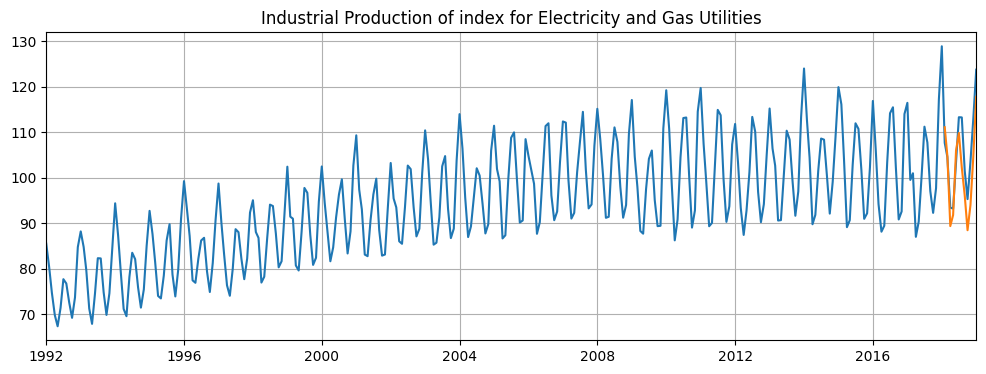

In [27]:
plt.figure(figsize=(12,4))
plt.title('Industrial Production of index for Electricity and Gas Utilities')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

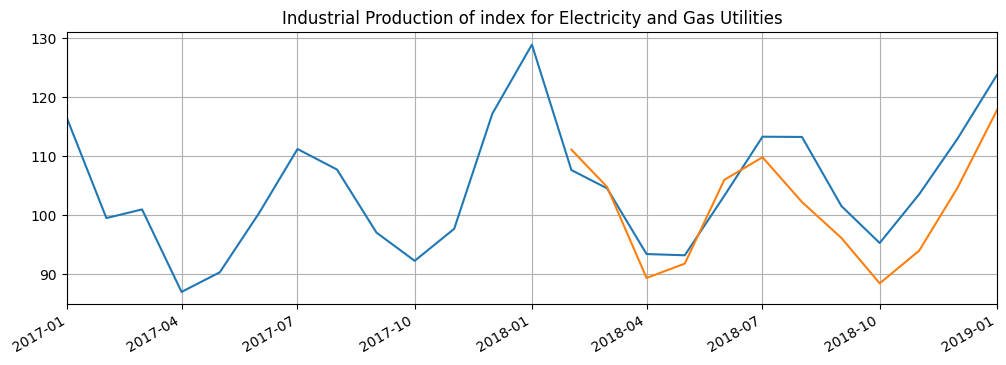

In [29]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production of index for Electricity and Gas Utilities')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

## END